# Isolation Forest Abnormal Recall Analysis

This notebook analyzes why the Isolation Forest model has low recall for the abnormal/anomaly class.

## 1. Load Libraries and Model

In [12]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
import json
warnings.filterwarnings('ignore')

In [ ]:
# Paths to your trained model and test dataset
model_path = './out/isolation_forest.joblib'
threshold_path = './out/threshold.json'
test_csv_path = './out/test.csv'
scaler_path = './out/scaler.joblib'  # if used

# Load trained Isolation Forest model
clf = joblib.load(model_path)
with open(threshold_path, "r") as f:
    threshold = json.load(f)["threshold"]

# Load test data
df_test = pd.read_csv(test_csv_path)
features = ['temp', 'pressure', 'vibration']
X_test = df_test[features]

# Apply scaler if used
if scaler_path:
    scaler = joblib.load(scaler_path)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

# Map labels
y_test = df_test['label'].str.lower().map({'normal':0, 'abnormal':1, 'unknown':np.nan})

In [59]:
full_df = pd.read_csv('./data/smart_factory_data.csv')
train = pd.read_csv('./out/train.csv')
test = pd.read_csv('./out/test.csv')

X = full_df[features]
X_train = train[features]
X_test = test[features]

# X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=features)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
X_scaled = pd.DataFrame(scaler.transform(X), columns=features)

pred = clf.predict(X_scaled)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

# Convert predictions to binary labels
pred = np.where(pred == 1, 0, 1)
pred_train = np.where(pred_train == 1, 0, 1)
pred_test = np.where(pred_test == 1, 0, 1)

# conver to series for value_counts
print(pd.Series(pred).value_counts())
print(pd.Series(pred_train).value_counts())
print(pd.Series(pred_test).value_counts())

1    495
0      5
Name: count, dtype: int64
1    400
Name: count, dtype: int64
1    100
Name: count, dtype: int64


In [67]:
clf = joblib.load('./out/isolation_forest.joblib')
clf.predict(X_test)
pred = clf.predict(X_test)
pred = np.where(pred == 1, 0, 1)
print(pd.Series(pred).value_counts())

1    100
Name: count, dtype: int64


In [69]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
                    n_estimators=200,
                    contamination=0.05,
                    max_samples='auto',
                    random_state=42,
                    n_jobs=-1,
                )
clf.fit(X_train)
pred = clf.predict(X_test)
pred = np.where(pred == 1, 0, 1)
print(pd.Series(pred).value_counts())

0    94
1     6
Name: count, dtype: int64


In [70]:
# save model
joblib.dump(clf, './out/isolation_forest.joblib')

['./out/isolation_forest.joblib']

In [71]:
clf = joblib.load('./out/isolation_forest.joblib')
clf.predict(X_test)
pred = clf.predict(X_test)
pred = np.where(pred == 1, 0, 1)
print(pd.Series(pred).value_counts())

0    94
1     6
Name: count, dtype: int64


## 2. Compute Predictions and Scores

In [15]:
# Decision scores (higher = more normal)
scores = clf.decision_function(X_test)
preds = (scores <= threshold).astype(int)  # anomaly=1

# Drop unknown labels
mask = ~y_test.isna()
y_test_eval = y_test[mask]
preds_eval = preds[mask]
scores_eval = scores[mask]

# Compute metrics
accuracy = accuracy_score(y_test_eval, preds_eval)
precision_normal = precision_score(y_test_eval, preds_eval, pos_label=0)
precision_abnormal = precision_score(y_test_eval, preds_eval, pos_label=1)
recall_normal = recall_score(y_test_eval, preds_eval, pos_label=0)
recall_abnormal = recall_score(y_test_eval, preds_eval, pos_label=1)
f1_normal = f1_score(y_test_eval, preds_eval, pos_label=0)
f1_abnormal = f1_score(y_test_eval, preds_eval, pos_label=1)
roc_auc = roc_auc_score(y_test_eval, -scores_eval)  # invert because low scores = anomalies

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (Normal): {precision_normal:.3f}")
print(f"Precision (Abnormal): {precision_abnormal:.3f}")
print(f"Recall (Normal): {recall_normal:.3f}")
print(f"Recall (Abnormal): {recall_abnormal:.3f}")
print(f"F1 (Normal): {f1_normal:.3f}")
print(f"F1 (Abnormal): {f1_abnormal:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Accuracy: 0.890
Precision (Normal): 1.000
Precision (Abnormal): 0.476
Recall (Normal): 0.878
Recall (Abnormal): 1.000
F1 (Normal): 0.935
F1 (Abnormal): 0.645
ROC-AUC: 1.000


## 3. Visualize Score Distributions

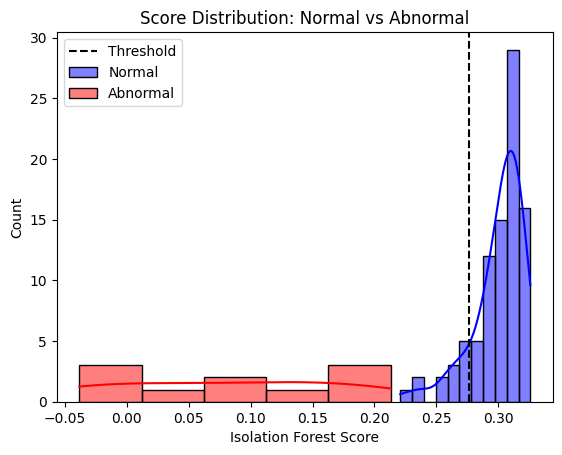

In [16]:
sns.histplot(scores_eval[y_test_eval==0], color='blue', label='Normal', kde=True)
sns.histplot(scores_eval[y_test_eval==1], color='red', label='Abnormal', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Isolation Forest Score')
plt.ylabel('Count')
plt.title('Score Distribution: Normal vs Abnormal')
plt.legend()
plt.show()

## 7. Summary and Analysis

- The score distributions show significant overlap between normal and abnormal samples.
- Misclassified abnormal samples tend to have feature values similar to normal samples.
- PCA visualization shows limited separability, explaining low abnormal recall.
- Possible improvements:
  - Use time-series models or sequence models if temporal dependencies exist.
  - Try other anomaly detection models such as One-Class SVM or Autoencoders.
  - Feature engineering or including additional features to better separate anomalies.

In [17]:
test = pd.read_csv('./data/smart_factory_data.csv')

In [18]:
test[test['label']=='abnormal']

,timestamp,temp,pressure,vibration,label
3,2025-09-24 23:11:00,48.481162,1.140787,0.022261,abnormal
5,2025-09-24 23:13:00,49.800164,1.031011,0.144123,abnormal
21,2025-09-24 23:29:00,46.700682,1.100795,0.026017,abnormal
23,2025-09-24 23:31:00,41.899181,1.014657,0.036780,abnormal
32,2025-09-24 23:40:00,46.620517,0.999355,0.098276,abnormal
33,2025-09-24 23:41:00,37.847703,1.038692,0.027406,abnormal
64,2025-09-25 00:12:00,52.795550,1.026959,0.022000,abnormal
75,2025-09-25 00:23:00,54.172179,1.024800,0.039443,abnormal
84,2025-09-25 00:32:00,45.187502,1.047074,0.241550,abnormal
86,2025-09-25 00:34:00,57.883293,0.998415,0.033882,abnormal


In [19]:
#output width setting
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [20]:
import pandas as pd

test = pd.read_csv('./data/smart_factory_data.csv')

# Assuming 'test' DataFrame exists
abnormal_rows = test[test['label'] == 'abnormal'].copy()

# Define strict anomaly thresholds
TEMP_LOW, TEMP_HIGH = 43.0, 52.0
PRESSURE_LOW, PRESSURE_HIGH = 0.97, 1.08
VIBRATION_HIGH = 0.07

def get_abnormal_features(row):
    features = []
    if pd.notna(row['temp']) and (row['temp'] < TEMP_LOW or row['temp'] > TEMP_HIGH):
        features.append('temp')
    if pd.notna(row['pressure']) and (row['pressure'] < PRESSURE_LOW or row['pressure'] > PRESSURE_HIGH):
        features.append('pressure')
    if pd.notna(row['vibration']) and row['vibration'] > VIBRATION_HIGH:
        features.append('vibration')
    return features

# Add a column listing abnormal features per row
abnormal_rows['abnormal_features'] = abnormal_rows.apply(get_abnormal_features, axis=1)

# Display the result
print(abnormal_rows[['timestamp','temp','pressure','vibration','abnormal_features']])


               timestamp       temp  pressure  vibration abnormal_features
3    2025-09-24 23:11:00  48.481162  1.140787   0.022261        [pressure]
5    2025-09-24 23:13:00  49.800164  1.031011   0.144123       [vibration]
21   2025-09-24 23:29:00  46.700682  1.100795   0.026017        [pressure]
23   2025-09-24 23:31:00  41.899181  1.014657   0.036780            [temp]
32   2025-09-24 23:40:00  46.620517  0.999355   0.098276       [vibration]
33   2025-09-24 23:41:00  37.847703  1.038692   0.027406            [temp]
64   2025-09-25 00:12:00  52.795550  1.026959   0.022000            [temp]
75   2025-09-25 00:23:00  54.172179  1.024800   0.039443            [temp]
84   2025-09-25 00:32:00  45.187502  1.047074   0.241550       [vibration]
86   2025-09-25 00:34:00  57.883293  0.998415   0.033882            [temp]
87   2025-09-25 00:35:00  47.364229  1.264546   0.032971        [pressure]
96   2025-09-25 00:44:00  59.552138  1.007824   0.038692            [temp]
110  2025-09-25 00:58:00 